### Importing the data

In [1]:
# importing necessary libraries:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

### Understanding data and manipulation

In [2]:
from sklearn.metrics import accuracy_score,recall_score, precision_score
from sklearn.model_selection import GridSearchCV

In [4]:
# importing dataset
dataset = pd.read_csv('../Churn.csv', na_values = [' ','','#NA','NA','NULL','NaN', 'nan', 'n/a'], 
                      dtype = {'TotalCharges':np.float32, 'MonthlyCharges': np.float32} )

In [5]:
print(dataset.shape)
dataset.head(3)

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.500000,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002,Yes


In [6]:
dataset.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761826,2283.298340
std,0.368612,24.559481,30.089973,2266.770508
min,0.000000,0.000000,18.250000,18.799999
25%,0.000000,9.000000,35.500000,401.450012
50%,0.000000,29.000000,70.349998,1397.475098
75%,0.000000,55.000000,89.849998,3794.737549
max,1.000000,72.000000,118.750000,8684.799805


In [7]:
# Dropping column not having any significance in predicting the customer decision so we will drop it
dataset.drop(columns = ['customerID', 'PaperlessBilling', 'PaymentMethod']
             , axis = 1, inplace = True)

<h4> Dealing with na values</h4>

In [8]:
#checking if any column in the data contain the na_values
dataset.isna().any()

gender              False
SeniorCitizen       False
Partner             False
Dependents          False
tenure              False
PhoneService        False
MultipleLines       False
InternetService     False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
Contract            False
MonthlyCharges      False
TotalCharges         True
Churn               False
dtype: bool

From above operation it can be observed that TotalCharges contains **na_values**..

In [9]:
total_rows_with_na_values = sum((dataset['TotalCharges'].isna())*1)
print(total_rows_with_na_values/dataset.shape[0])

0.001561834445548772


Here, 0.15 % of total data contains **na** values so removing it will not have any significant affect on value of our data.<br>
But, here we are going to keep it in the data by *replacing it with the mean of the column*.

In [10]:
dataset['TotalCharges'].fillna(dataset['TotalCharges'].mean(), inplace = True)
print("Is there any na value left in dataset:",dataset['TotalCharges'].isna().any())

Is there any na value left in dataset: False


<h4> Dividing the data in X and y</h4>

In [11]:
X = dataset.iloc[:,:-1].values
y = (dataset.iloc[:,-1].values == 'Yes')*1

<h4> Encoding the values and feature scaling</h4>

In [12]:
# encoding of labels of dataset
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

for i in range(X.shape[1]):
    # for encoding of all columns having unique values lower than 5
    if len(np.unique(X[:,i])) < 5:
        X[:,i] = label_encoder.fit_transform(X[:,i])

In [13]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


<h4> Dealing multi-collinearity</h4>

The variance inflation factor is a measure for the increase of the
variance of the parameter estimates if an additional variable, given by
exog_idx is added to the linear regression. It is a measure for
multicollinearity of the design matrix, exog.

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X[:, variables], i) for i in range(X[:, variables].shape[1])]
        maxloc = vif.index(max(vif))
        print(max(vif))
        
        if max(vif) > thresh:
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(variables)
    return X[:, variables]

In [15]:
X = calculate_vif_(X, 5)

10.296378756521603
2.618606646233099
Remaining variables:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


<h4>Building optimal model using backward elimination</h4>

The adjusted R-squared is a modified version of R-squared that has been adjusted for the number of predictors in the model. The adjusted R-squared increases only if the new term improves the model more than would be expected by chance. It decreases when a predictor improves the model by less than expected by chance.<br>
 The p-value is a number between 0 and 1 and interpreted in the following way: A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis.<br>
A null hypothesis is a type of hypothesis used in statistics that proposes that no statistical significance exists in a set of given observations. The null hypothesis attempts to show that no variation exists between variables or that a single variable is no different than its mean.

In [16]:
import statsmodels.formula.api as sm

def backwardElimination(x,y, SL):
    numVars = len(x[0])
    temp = np.zeros((x.shape[0],numVars)).astype(int)
    
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y, x).fit()
        
        maxVar = max(regressor_OLS.pvalues).astype(float)
        
        adjR_before = regressor_OLS.rsquared_adj.astype(float)
        
        if maxVar > SL:
            
            for j in range(0, numVars - i):
                
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    temp[:,j] = x[:, j]
                    x = np.delete(x, j, 1)
                    
                    tmp_regressor = sm.OLS(y, x).fit()
                    adjR_after = tmp_regressor.rsquared_adj.astype(float)
                    
                    if (adjR_before >= adjR_after):
                        x_rollback = np.hstack((x, temp[:,[0,j]]))
                        x_rollback = np.delete(x_rollback, j, 1)
                        print (regressor_OLS.summary())
                        return x_rollback
                    else:
                        continue
    regressor_OLS.summary()
    return x
 


In [17]:
X = np.append(arr = np.ones((X.shape[0], 1)).astype(int), values = X, axis = 1)

In [18]:
SL = 0.05
X_opt = X[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]]
X_Modeled = backwardElimination(X_opt,y, SL)

<h4> Now Splitting Dataset into training and test set</h4>

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_Modeled, y, test_size = 0.4, random_state = 32)

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. The best value is 1 and the worst value is 0.<br><br>
The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples. The best value is 1 and the worst value is 0.<br>

<h4>Visualization</h4>

In [20]:
import seaborn as sns

In [21]:
# choosing only 1000 tuple from each class for better visualization
churn1 = dataset[dataset['Churn'] == 'Yes'][:1000]
churn0 = dataset[dataset['Churn'] == 'No'][:1000]

<h4>Total Charges VS Monthly Charges</h4>

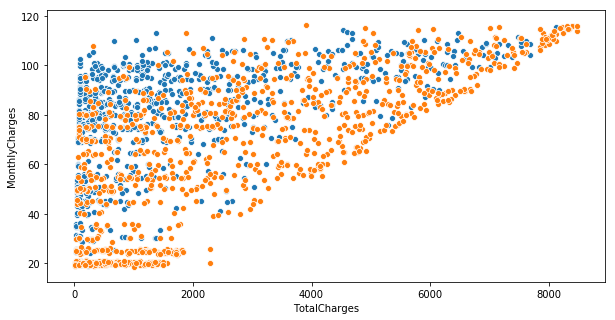

In [22]:
plt.figure(figsize = (10,5))
sns.scatterplot('TotalCharges', 'MonthlyCharges',data=churn1)
sns.scatterplot('TotalCharges', 'MonthlyCharges',data=churn0)
plt.show()

From above graph it can be observed that we couldn't classify our data on the basis of Monthly Charges and Total Charges.

<h4>Tenure VS Total Charges</h4>

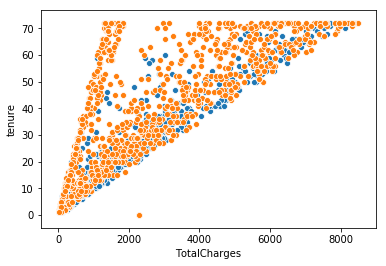

In [23]:
sns.scatterplot('TotalCharges', 'tenure',data=churn1)
sns.scatterplot('TotalCharges', 'tenure',data=churn0)
plt.show()

tenure and TotalCharges can also not be used for classification task.

<h4>Tenure VS Monthly Charges</h4>

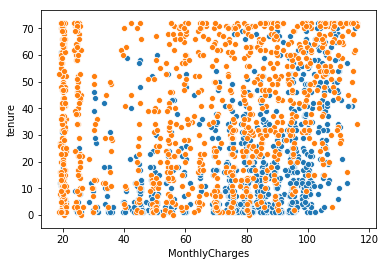

In [24]:
sns.scatterplot('MonthlyCharges', 'tenure',data=churn1)
sns.scatterplot('MonthlyCharges', 'tenure',data=churn0)
plt.show()

Tenure and Monthly can also not be used for classification.

<h4> Dimensionality reduction to visualize the data</h4>

In [25]:
from mpl_toolkits.mplot3d import Axes3D

In [26]:
from numpy import linalg as LA

print(X_test.shape)
sigma = (1/X_test.shape[0])*np.matmul(X_test.T, X_test)
u,s,v = np.linalg.svd(sigma)

(2818, 13)


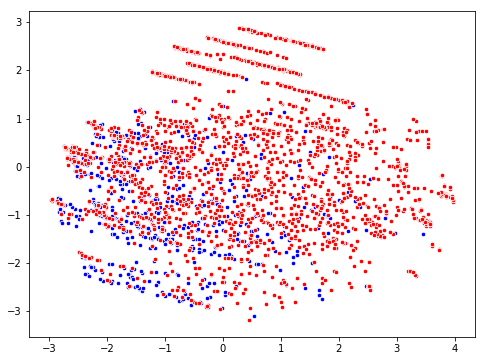

In [41]:
# Reducing the X_test from 13 dimension to 2 dimension
z2 = np.matmul(X_test, u[:,:2])

churn1 = z2[y_test == 1]
churn0 = z2[y_test == 0]

plt.figure(figsize = (8,6))
sns.scatterplot(churn1[:,0], churn1[:,1], color = 'blue', s = 20)
sns.scatterplot(churn0[:,0],churn0[:,1], color = 'red', s = 20)
plt.show()

Here it is not quite clear but we can say that blue is more dense at the bottom and red dots are more dense at the top.

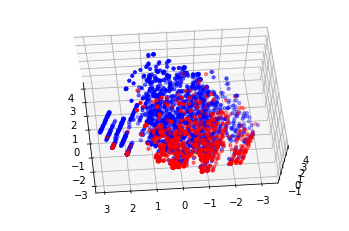

In [71]:
### Reducing the X_test from 13 dimension to 2 dimension
z = np.matmul(X_test, u[:,:3])

churn1 = z[y_test == 1]
churn0 = z[y_test == 0]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', navigate =True)
ax.scatter(churn0[:,0], churn0[:,1], churn0[:,2], c='blue', s=10)
ax.scatter(churn1[:,0], churn1[:,1], churn1[:,2],  c='red', s=10)
ax.view_init(70, 175)
plt.draw()

Here we can easily observe cluster of red dots i.e. Churn 'Yes' and blue dot i.e. Churn 'No'.

### Implementing Machine Learning Models

In [33]:
def model_evaluation(classifier, X, y):
    y_pred = classifier.predict(X)
    print("accuracy score:",accuracy_score(y, y_pred))
    print("precision score:",precision_score(y, y_pred))
    print("recall score",recall_score(y, y_pred))

<h4>Naive Bayes Classifier</h4>

In [33]:
from sklearn.naive_bayes import GaussianNB
naiveBayesClassifier = GaussianNB()
naiveBayesClassifier.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [34]:
print("***Training***")
model_evaluation(naiveBayesClassifier, X_train,y_train)
print("***Testing***")
model_evaluation(naiveBayesClassifier,X_test,y_test)

***Training***
accuracy score: 0.7582534611288605
precision score: 0.5229268292682927
recall score 0.7362637362637363
***Testing***
accuracy score: 0.7452093683463449
precision score: 0.5498154981549815
recall score 0.7215496368038741


<h4>Logistic Regression</h4>

In [53]:
from sklearn.linear_model import LogisticRegression
logistic_classifier = LogisticRegression(random_state = 32, solver = 'lbfgs')
logistic_classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=32, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [54]:
print("***Training***")
model_evaluation(logistic_classifier, X_train,y_train)
print("***Testing***")
model_evaluation(logistic_classifier,X_test,y_test)

***Training***
accuracy score: 0.8056443024494143
precision score: 0.6525781910397295
recall score 0.5302197802197802
***Testing***
accuracy score: 0.7892122072391767
precision score: 0.6946308724832215
recall score 0.5012106537530266


<h4>KNN</h4>

In [58]:
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier(n_neighbors = 9, p = 1, weights = 'uniform', leaf_size = 15, algorithm = 'ball_tree')
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=15, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=9, p=1,
           weights='uniform')

In [63]:
# it will take some time but will return the best perimeter to run on the classifier
# then again run the classifier with the new parameters and fit on training set
parameters = [{'n_neighbors': [5,7,9], 'weights':['uniform','distance'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'leaf_size':[15,30, 45], 'p':[1,2], }]


grid_search = GridSearchCV(estimator = knn_classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)

grid_search = grid_search.fit(X_train, y_train)

best_parameters = grid_search.best_params_
print("best score on the parameter on 10 folds is :",grid_search.best_score_)
print(best_parameters)

best score on the parameter on 10 folds is : 0.7777777777777778
{'leaf_size': 20}


In [69]:
print("***Training***")
model_evaluation(knn_classifier, X_train,y_train)
print("***Testing***")
model_evaluation(knn_classifier,X_test,y_test)

***Training***
accuracy score: 0.8239261625843095
precision score: 0.6972789115646258
recall score 0.5631868131868132
***Testing***
accuracy score: 0.7707594038325053
precision score: 0.6510067114093959
recall score 0.46973365617433416


<h4>SVM</h4>

In [68]:
from sklearn.svm import SVC
Svm_classifier = SVC(kernel = 'linear', random_state = 32, C = 1)
Svm_classifier.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=32,
  shrinking=True, tol=0.001, verbose=False)

In [67]:
# This block will take some time to find best perimeter of the classifier
parameters = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
grid_search = GridSearchCV(estimator = Svm_classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_

print("best score on the parameter on 10 folds is :",grid_search.best_score_)
print(best_parameters)

best score on the parameter on 10 folds is : 0.8013844515441959
{'C': 1, 'kernel': 'linear'}


In [70]:
print("***Training***")
model_evaluation(Svm_classifier, X_train,y_train)
print("***Testing***")
model_evaluation(Svm_classifier,X_test,y_test)

***Training***
accuracy score: 0.8020944266950657
precision score: 0.6382806163828062
recall score 0.540521978021978
***Testing***
accuracy score: 0.78708303761533
precision score: 0.6840390879478827
recall score 0.5084745762711864


You could try grid search method on decision tree and random forest also but since it is taking 5-10 minutes approx. so we are not using it later.

<h4> Decision Tree Classification</h4>

In [72]:
from sklearn.tree import DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [73]:
print("***Training***")
model_evaluation(dt_classifier, X_train,y_train)
print("***Testing***")
model_evaluation(dt_classifier,X_test,y_test)

***Training***
accuracy score: 0.9921902733404331
precision score: 0.9930167597765364
recall score 0.9766483516483516
***Testing***
accuracy score: 0.7487579843860894
precision score: 0.5865102639296188
recall score 0.48426150121065376


<h4>Random Forest Classification</h4>

In [80]:
# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
rdt_classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
rdt_classifier.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [81]:
print("***Training***")
model_evaluation(rdt_classifier, X_train,y_train)
print("***Testing***")
model_evaluation(rdt_classifier,X_test,y_test)

***Training***
accuracy score: 0.9921902733404331
precision score: 0.9835616438356164
recall score 0.9862637362637363
***Testing***
accuracy score: 0.7665010645848119
precision score: 0.6337579617834395
recall score 0.48184019370460046


Decision Tree and Random Forest Classifier both having huge difference between their train set accuracy and test set accuracy, so their is surely overfitting. That's why we will not consider any further. Till now logistic Regression and 
SVM classifier is out performing others considering accuracy, precision and recall score combined instead Naive bayes has the best recall score.

We could use model with higher recall or may be with higher precision according to the need and situation.

<h4>Artificial Neural Network</h4>

In [82]:
import keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [96]:
# Initialising the ANN
classifier = Sequential()

classifier.add(Dense(output_dim = 64, init = 'glorot_uniform', activation = 'relu', input_dim = 13))

classifier.add(Dense(output_dim = 128, init = 'glorot_uniform', activation = 'relu'))

classifier.add(Dense(output_dim = 64, init = 'glorot_uniform', activation = 'relu'))

classifier.add(Dense(output_dim = 32, init = 'glorot_uniform', activation = 'relu'))

classifier.add(Dense(output_dim = 1, init = 'glorot_uniform', activation = 'sigmoid'))

classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train, y_train, batch_size = 32, epochs = 100)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=13, units=64, kernel_initializer="glorot_uniform")`
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128, kernel_initializer="glorot_uniform")`
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=64, kernel_initializer="glorot_uniform")`
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=32, kernel_initializer="glorot_uniform")`
  # Remove the CWD from sys.path while we load stuff.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation

Epoch 1/100
5634/5634 [==============================] - 1s 242us/step - loss: 0.4431 - acc: 0.7875
Epoch 2/100
5634/5634 [==============================] - 0s 74us/step - loss: 0.4190 - acc: 0.8023
Epoch 3/100
5634/5634 [==============================] - 0s 72us/step - loss: 0.4109 - acc: 0.8060
Epoch 4/100
5634/5634 [==============================] - 0s 70us/step - loss: 0.4107 - acc: 0.8042
Epoch 5/100
5634/5634 [==============================] - 0s 73us/step - loss: 0.4060 - acc: 0.8095
Epoch 6/100
5634/5634 [==============================] - 0s 72us/step - loss: 0.4034 - acc: 0.8074
Epoch 7/100
5634/5634 [==============================] - 0s 75us/step - loss: 0.4024 - acc: 0.8097
Epoch 8/100
5634/5634 [==============================] - 0s 72us/step - loss: 0.3994 - acc: 0.8104
Epoch 9/100
5634/5634 [==============================] - 0s 71us/step - loss: 0.4010 - acc: 0.8104
Epoch 10/100
5634/5634 [==============================] - 0s 77us/step - loss: 0.3977 - acc: 0.8111
Epoch 11

In [97]:
print("***Training***")
y_train_pred = classifier.predict_classes(X_train)
print("accuracy: ", accuracy_score(y_train,y_train_pred))
print("precision: ", precision_score(y_train,y_train_pred))
print("recall: ", recall_score(y_train,y_train_pred))

print("***Testing***")
y_test_pred = classifier.predict_classes(X_test)
print("accuracy: ", accuracy_score(y_test,y_test_pred))
print("precision: ", precision_score(y_test,y_test_pred))
print("recall: ", recall_score(y_test,y_test_pred))

***Training***
accuracy:  0.8883564075257366
precision:  0.7632081476766391
recall:  0.823489010989011
***Testing***
accuracy:  0.7473385379701917
precision:  0.5664335664335665
recall:  0.5883777239709443


After 100 epochs on the training set the model is showing an accuracy of approx. 88.8% on training set and approx 75% on test set. Neural networks requires a large amount but here is scarcity of it. But, even then it has out performed all the previous conventional models.

<h3>Conclusion</h3>

Artificial Neural Network out performed all the other classification technique. With large amount of data, bigger and deeper network the problem of vanishing and exploding gradient can be solved by using LSTM (i.e. Long Short Term Memory) we could have a model which could achieve state of art performance.<br><br>
 
**Neural Network accuracy:**<br>
On the training set : 0.8883564075257366<br>
    On the test set : 0.7473385379701917<br>